This version adds the transforms back in and (maybe?) adds in normalization. Also uses a deeper ResNet

# Imports and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Dogs Project')
gdrive_path = os.getcwd()

In [3]:
# update google colab to the latest version of fastai
!pip install -Uqq fastai

     |████████████████████████████████| 194kB 13.2MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 


In [4]:
!pip install PyGithub

     |████████████████████████████████| 296kB 13.3MB/s 


In [5]:
import os
import shutil
from datetime import datetime
import numpy as np
import pandas as pd
import tarfile
from io import BytesIO
from base64 import b64encode
from github import Github
from IPython.display import Markdown, display

# according to fastai book, use the star import notation despite python best practices
from fastai.vision.all import *
from fastai.vision.widgets import *

In [6]:
SEED = 42

def set_seed(seed, dls=None, use_cuda=True):
    # For reproducibility. Run before any fits.
    # see 1: https://github.com/fastai/fastai/issues/2832 and
    # and 2: https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/28
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    random.seed(seed) # Python

    if dls is not None:  # DataLoaders object
        dls.rng.seed(seed)

    if use_cuda: # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [7]:
VALID_PCT = 0.2
TEST_PCT = 0.1
IMAGE_SIZE = 128

# Download, organize, and import data

In [8]:
# remove pre-downloaded files if necessary

try:
    shutil.rmtree('/root/.fastai')
except FileNotFoundError:
    pass

In [9]:
# this function is necessary because the tar file does not have .tgz extension
def extract_tar(fname, destparent):
    tarfile.open(fname).extractall(destparent)

# download and extract Stanford dogs dataset
download_path = untar_data('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar', extract_func=extract_tar)

In [10]:
# rename folders to be just the dog breed name
# e.g., change "n02109047-Great_Dane" to "Great Dane"

rename_dogs = {"Airedale" : "Airedale Terrier",
    "Basset" : "Basset Hound",
    "Boston Bull" : "Boston Terrier",
    "Cairn" : "Cairn Terrier",
    "Cardigan" : "Cardigan Welsh Corgi",
    "Chow" : "Chow Chow",
    "Dingo" : "Carolina Dog",
    "Entlebucher" : "Entlebucher Mountain Dog",
    "Pekinese" : "Pekingese",
    "Pembroke" : "Pembroke Welsh Corgi",
    "Scotch Terrier" : "Scottish Terrier",
}

for path in download_path.ls():
    old_folder = os.path.basename(path)
    new_folder = old_folder[10:].replace('_', ' ').title()  # replace underscore with space, then proper case
    new_folder = rename_dogs.get(new_folder, new_folder)
    path.rename(download_path / new_folder)

download_path.ls()

(#120) [Path('/root/.fastai/data/images/Norwich Terrier'),Path('/root/.fastai/data/images/Irish Terrier'),Path('/root/.fastai/data/images/Cairn Terrier'),Path('/root/.fastai/data/images/German Shepherd'),Path('/root/.fastai/data/images/Norfolk Terrier'),Path('/root/.fastai/data/images/Rottweiler'),Path('/root/.fastai/data/images/Boston Terrier'),Path('/root/.fastai/data/images/Chihuahua'),Path('/root/.fastai/data/images/English Springer'),Path('/root/.fastai/data/images/Carolina Dog')...]

## Get images for additional dog breeds

These breeds are not in Stanford dogs list but that are in the top 100 in 2018 Rank on AKC's Most Popular Dog Breeds List. In addition, I've included 3 common mixed-breed dogs in this list.

https://www.akc.org/expert-advice/news/most-popular-dog-breeds-full-ranking-list/

In [11]:
new_dogs = ['Akita',
    'Anatolian Shepherd Dog',
    'Australian Cattle Dog',
    'Australian Shepherd',
    'Bichon Frise',
    'Boykin Spaniel',
    'Bull Terrier',
    'Cane Corso',
    'Cavalier King Charles Spaniel',
    'Chinese Crested',
    'Chinese Shar-Pei',
    'Coton de Tulear',
    'Dachshund',
    'Dalmatian',
    'Dogues de Bordeaux',
    'English Bulldog',
    'English Mastiff',
    'German Wirehaired Pointer',
    'Havanese',
    'Lagotto Romagnolo',
    'Miniature American Shepherd',
    'Nova Scotia Duck Tolling Retriever',
    'Portuguese Water Dog',
    'Rat Terrier',
    'Russell Terrier',
    'Shiba Inu',
    'Wirehaired Pointing Griffon',
    'Cockapoo',
    'Goldendoodle',
    'Labradoodle',
]

In [12]:
# from fastbook (fastai book), https://github.com/fastai/fastbook/blob/master/utils.py

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'minHeight':min_sz, 'minWidth':min_sz, 'imageType': 'photo'}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()
     return L(search_results['value']).filter(lambda y: (y['encodingFormat'].lower() in ['jpg', 'jpeg']) and ('?' not in y['contentUrl']))

In [13]:
with open('bing_key.key', 'r') as f:
    bing_key = f.read().strip()

for dog in new_dogs:
    print(f'Starting {dog}...')
    dest = (download_path / dog)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(bing_key, dog + " dog", max_images=150)  # append the word "dog" to searches
    urls = results.attrgot('contentUrl')
    download_images(dest, urls=urls)

print('Done')

Starting Akita...
Starting Anatolian Shepherd Dog...
Starting Australian Cattle Dog...
Starting Australian Shepherd...
Starting Bichon Frise...
Starting Boykin Spaniel...
Starting Bull Terrier...
Starting Cane Corso...
Starting Cavalier King Charles Spaniel...
Starting Chinese Crested...
Starting Chinese Shar-Pei...
Starting Coton de Tulear...
Starting Dachshund...
Starting Dalmatian...
Starting Dogues de Bordeaux...
Starting English Bulldog...
Starting English Mastiff...
Starting German Wirehaired Pointer...
Starting Havanese...
Starting Lagotto Romagnolo...
Starting Miniature American Shepherd...
Starting Nova Scotia Duck Tolling Retriever...
Starting Portuguese Water Dog...
Starting Rat Terrier...
Starting Russell Terrier...
Starting Shiba Inu...
Starting Wirehaired Pointing Griffon...
Starting Cockapoo...
Starting Goldendoodle...
Starting Labradoodle...
Done


In [14]:
# verify images; remove any corrupted images

# note: I forgot to include the "else" below, so it was always printing "All are ok", even 
# if there were corrupt images
for dog in new_dogs:
    dog_path = (download_path / dog)
    fns = get_image_files(dog_path)
    print(f'{dog} has {len(fns)} images...', end="")
    failed = verify_images(fns)
    if len(failed) > 0:
        print(f"{len(failed)} are corrupt ({len(fns) - len(failed)} are left)")
        failed.map(Path.unlink)
    else:
        print("All are ok")

Akita has 142 images...1 are corrupt (141 are left)
Anatolian Shepherd Dog has 144 images...3 are corrupt (141 are left)
Australian Cattle Dog has 142 images...8 are corrupt (134 are left)
Australian Shepherd has 145 images...2 are corrupt (143 are left)
Bichon Frise has 142 images...1 are corrupt (141 are left)
Boykin Spaniel has 138 images...All are ok
Bull Terrier has 141 images...All are ok
Cane Corso has 138 images...All are ok
Cavalier King Charles Spaniel has 142 images...2 are corrupt (140 are left)
Chinese Crested has 140 images...1 are corrupt (139 are left)
Chinese Shar-Pei has 138 images...All are ok
Coton de Tulear has 145 images...All are ok
Dachshund has 141 images...All are ok
Dalmatian has 144 images...2 are corrupt (142 are left)
Dogues de Bordeaux has 136 images...All are ok
English Bulldog has 140 images...All are ok
English Mastiff has 146 images...1 are corrupt (145 are left)
German Wirehaired Pointer has 140 images...All are ok
Havanese has 145 images...All are o

In [15]:
# View images, clean up if necessary and have time
# Note, this widget will not appear in nbviewer. It allows you to use dropdowns to "keep" or
# "delete" images

"""
dog_i = 0  # 0 to 29
img_i = 1  # 0 to 5
dog_path = (download_path / new_dogs[dog_i])
fns = get_image_files(dog_path)
fns_subset = fns[(img_i * 30):((img_i * 30) + 30)]
w = ImagesCleaner(max_n=30)
w.set_fns(fns_subset)
print(new_dogs[dog_i])
w
"""

'\ndog_i = 0  # 0 to 29\nimg_i = 1  # 0 to 5\ndog_path = (download_path / new_dogs[dog_i])\nfns = get_image_files(dog_path)\nfns_subset = fns[(img_i * 30):((img_i * 30) + 30)]\nw = ImagesCleaner(max_n=30)\nw.set_fns(fns_subset)\nprint(new_dogs[dog_i])\nw\n'

In [16]:
# zip up the new dogs from bing
cwd = os.getcwd()
os.chdir(download_path)
!zip -r bing_dogs.zip 'Akita' 'Anatolian Shepherd Dog' 'Australian Cattle Dog' 'Australian Shepherd' 'Bichon Frise' 'Boykin Spaniel' 'Bull Terrier' 'Cane Corso' 'Cavalier King Charles Spaniel' 'Chinese Crested' 'Chinese Shar-Pei' 'Coton de Tulear' 'Dachshund' 'Dalmatian' 'Dogues de Bordeaux' 'English Bulldog' 'English Mastiff' 'German Wirehaired Pointer' 'Havanese' 'Lagotto Romagnolo' 'Miniature American Shepherd' 'Nova Scotia Duck Tolling Retriever' 'Portuguese Water Dog' 'Rat Terrier' 'Russell Terrier' 'Shiba Inu' 'Wirehaired Pointing Griffon' 'Cockapoo' 'Goldendoodle' 'Labradoodle'
shutil.copy(os.path.join(str(download_path), "bing_dogs.zip"), os.path.join(gdrive_path, "bing_dogs.zip"))
os.chdir(gdrive_path)

  adding: Akita/ (stored 0%)
  adding: Akita/00000004.jpg (deflated 0%)
  adding: Akita/00000046.jpg (deflated 0%)
  adding: Akita/00000012.jpg (deflated 2%)
  adding: Akita/00000134.jpg (deflated 0%)
  adding: Akita/00000103.jpg (deflated 1%)
  adding: Akita/00000054.jpg (deflated 0%)
  adding: Akita/00000117.jpg (deflated 32%)
  adding: Akita/00000061.jpg (deflated 0%)
  adding: Akita/00000053.jpg (deflated 1%)
  adding: Akita/00000106.jpg (deflated 1%)
  adding: Akita/00000035.jpg (deflated 0%)
  adding: Akita/00000044.jpg (deflated 0%)
  adding: Akita/00000100.jpg (deflated 0%)
  adding: Akita/00000128.jpg (deflated 0%)
  adding: Akita/00000045.jpg (deflated 14%)
  adding: Akita/00000113.jpg (deflated 0%)
  adding: Akita/00000080.jpg (deflated 0%)
  adding: Akita/00000009.jpg (deflated 0%)
  adding: Akita/00000019.jpg (deflated 0%)
  adding: Akita/00000020.jpg (deflated 0%)
  adding: Akita/00000024.jpg (deflated 0%)
  adding: Akita/00000111.jpg (deflated 0%)
  adding: Akita/0000012

## Make test set

In [17]:
# Create a separate test set that is invisible to fastai. I had concerns that fastai was memorizing 
# the training set, as it gave > 99% accuracy on images from the training set, but low accuracy
# on new images (e.g., classifying a dingo image as a whippet).

set_seed(SEED)
for path in download_path.ls():
    files = list(get_image_files(path))
    test_count = int(len(files) * TEST_PCT)
    test_files = list(np.random.choice(files, size=test_count, replace=False))

    new_path = str(path).replace('images', 'test_images')
    print(new_path)
    os.makedirs(new_path, exist_ok=True)
    for test_file in test_files:
        test_file.rename(os.path.join(new_path, os.path.basename(test_file)))

    print(f'Moved {test_count} from {str(path)} to {new_path}')

/root/.fastai/data/test_images/English Bulldog
Moved 14 from /root/.fastai/data/images/English Bulldog to /root/.fastai/data/test_images/English Bulldog
/root/.fastai/data/test_images/Australian Shepherd
Moved 14 from /root/.fastai/data/images/Australian Shepherd to /root/.fastai/data/test_images/Australian Shepherd
/root/.fastai/data/test_images/Norwich Terrier
Moved 18 from /root/.fastai/data/images/Norwich Terrier to /root/.fastai/data/test_images/Norwich Terrier
/root/.fastai/data/test_images/English Mastiff
Moved 14 from /root/.fastai/data/images/English Mastiff to /root/.fastai/data/test_images/English Mastiff
/root/.fastai/data/test_images/Irish Terrier
Moved 16 from /root/.fastai/data/images/Irish Terrier to /root/.fastai/data/test_images/Irish Terrier
/root/.fastai/data/test_images/Russell Terrier
Moved 14 from /root/.fastai/data/images/Russell Terrier to /root/.fastai/data/test_images/Russell Terrier
/root/.fastai/data/test_images/Cairn Terrier
Moved 19 from /root/.fastai/dat

In [18]:
# check that there are no images overlapping between /images/ and /test_images/
# show all images in both sets
dog = 'Miniature Pinscher'
train_imgs = [str(x) for x in (Path('/root/.fastai/data/images')/dog).ls()]
test_imgs = [str(x) for x in (Path('/root/.fastai/data/test_images')/dog).ls()]
print([x for x in test_imgs if x in train_imgs])

[]


## Make training + validation sets

Note: we want to split our data in a stratified way so that we don't have imbalanced classes. We will do this by making a dataframe containing all of the images, then randomly choose 20% of each class to be in the validation set.

In [19]:
dat = []

set_seed(SEED)
for path in download_path.ls():  # for each dog breed
    tmp_files = [str(x) for x in get_image_files(path)]

    val_count = int(len(tmp_files) * VALID_PCT)
    val_files = list(np.random.choice(tmp_files, size=val_count, replace=False))
    train_files = [x for x in tmp_files if x not in val_files]

    # [path, label, is_valid]
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 False] for file in train_files])
    dat.extend([[parent_label(file) + '/' + os.path.basename(file), 
                 parent_label(file), 
                 True] for file in val_files])

df = pd.DataFrame(dat, columns=['file', 'label', 'is_valid'])
df.head()

file            label  is_valid
0  English Bulldog/00000117.JPG  English Bulldog     False
1  English Bulldog/00000046.jpg  English Bulldog     False
2  English Bulldog/00000012.jpg  English Bulldog     False
3  English Bulldog/00000103.jpg  English Bulldog     False
4  English Bulldog/00000054.jpg  English Bulldog     False

In [20]:
# check that we've stratified correctly
df.groupby(['label']).agg({'is_valid':lambda x: sum(x == True) / len(x)}).reset_index()

label  is_valid
0                  Affenpinscher  0.200000
1                   Afghan Hound  0.199074
2            African Hunting Dog  0.196078
3               Airedale Terrier  0.197802
4                          Akita  0.196850
..                           ...       ...
145  West Highland White Terrier  0.196078
146                      Whippet  0.195266
147      Wire-Haired Fox Terrier  0.197183
148  Wirehaired Pointing Griffon  0.198473
149            Yorkshire Terrier  0.195946

[150 rows x 2 columns]

In [21]:
# Note: we resize all images to the same size, padding with 0s (black) if the aspect ratio of
# the original image isn't right. We also augment batches to include transformed versions of our 
# images in each batch during training (rotation, flipping, perspective warping, brightness, and contrast).
# We do this on an entire batch at once instead of on an individual image basis because all images
# will be the same size by the time the batch is running.

dls = ImageDataLoaders.from_df(df,
    path='/root/.fastai/data/images',
    seed=SEED,
    fn_col=0,
    label_col=1,
    valid_col=2,
    y_block=CategoryBlock,
    item_tfms=RandomResizedCrop(IMAGE_SIZE, min_scale=0.5),
    batch_tfms=aug_transforms())  # default augmentation

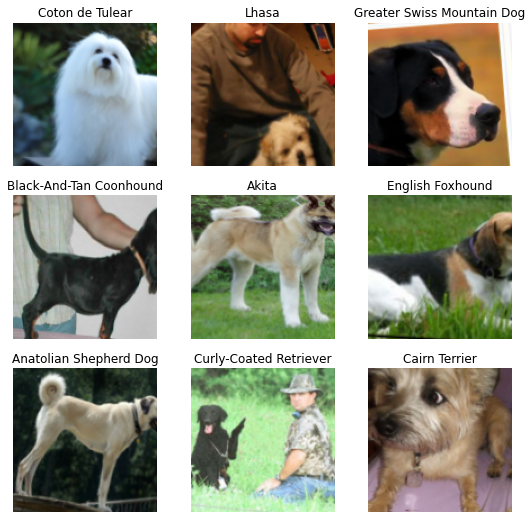

In [22]:
dls.train.show_batch()

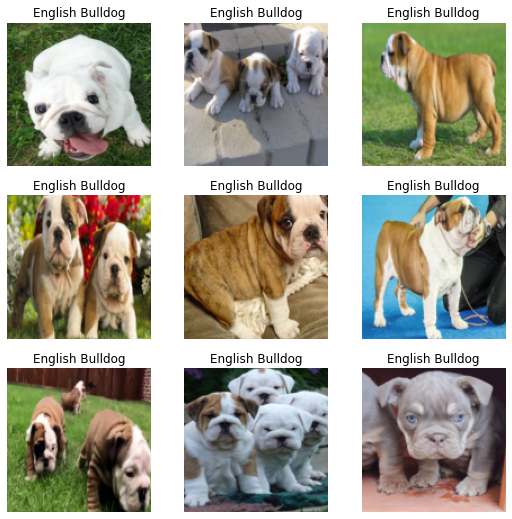

In [23]:
# good! we have data in the validation set
# notice: no transformations/augmentation done to validation set, only resize/crop
dls.valid.show_batch()

# Model training & interpretation

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


(0.005754399299621582, 0.0063095735386013985)


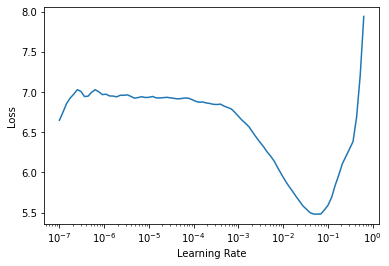

In [24]:
set_seed(SEED, dls=dls)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()
print((lr_min, lr_steep))

In [25]:
# 3 epochs with ResNet layers frozen, training new layers
# 5 additional epochs

set_seed(SEED, dls=dls)
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(epochs=5, 
                freeze_epochs=3, 
                base_lr=lr_steep)
                #cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=5))

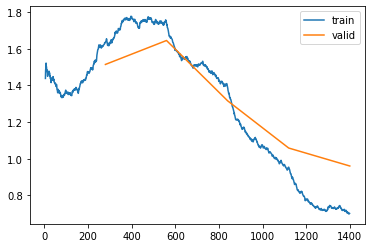

In [26]:
learn.recorder.plot_loss()

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

# Instead of showing confusion matrix (which would be 120x120, since we have 120 dog breeds) [149 with added breeds],
# get counts of the breeds that were most confused for one another
interp.most_confused(min_val=5)

[('Eskimo Dog', 'Siberian Husky', 13),
 ('Entlebucher Mountain Dog', 'Greater Swiss Mountain Dog', 11),
 ('Lhasa', 'Shih-Tzu', 11),
 ('Malamute', 'Siberian Husky', 10),
 ('Shetland Sheepdog', 'Collie', 10),
 ('Collie', 'Border Collie', 9),
 ('English Foxhound', 'Walker Hound', 9),
 ('Great Pyrenees', 'Kuvasz', 9),
 ('Wirehaired Pointing Griffon', 'German Wirehaired Pointer', 9),
 ('Yorkshire Terrier', 'Silky Terrier', 9),
 ('Toy Poodle', 'Miniature Poodle', 8),
 ('Black-And-Tan Coonhound', 'Doberman', 7),
 ('Cockapoo', 'Goldendoodle', 7),
 ('Appenzeller', 'Greater Swiss Mountain Dog', 6),
 ('Australian Shepherd', 'Miniature American Shepherd', 6),
 ('German Shepherd', 'Malinois', 6),
 ('Labradoodle', 'Goldendoodle', 6),
 ('Miniature Poodle', 'Standard Poodle', 6),
 ('Rhodesian Ridgeback', 'Redbone', 6),
 ('Samoyed', 'Great Pyrenees', 6),
 ('Scottish Deerhound', 'Irish Wolfhound', 6),
 ('Silky Terrier', 'Yorkshire Terrier', 6),
 ('Toy Terrier', 'Miniature Pinscher', 6),
 ('Whippet', 'It

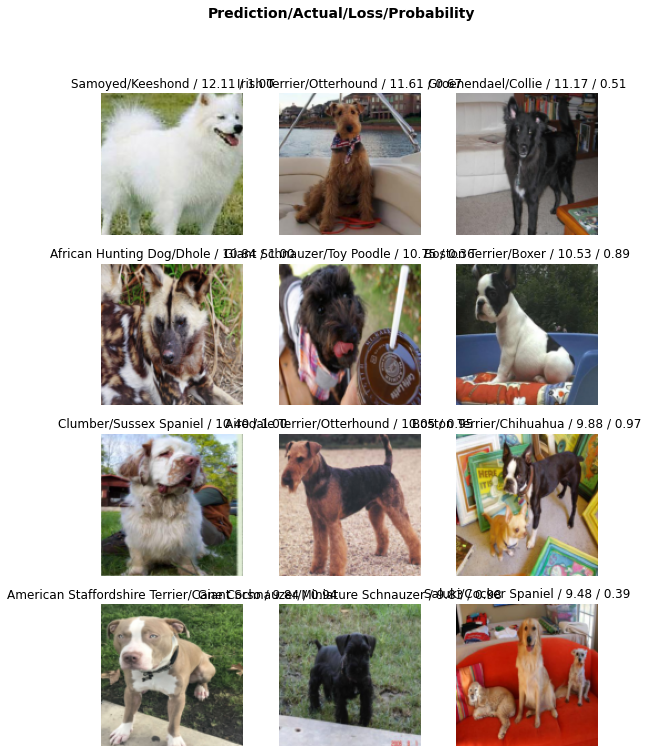

In [28]:
# show the images with the highest losses in our dataset
# titles are: (prediction, actual, loss, and probability)
interp.plot_top_losses(12, nrows=4)

In [29]:
# save our model
learn.export(os.path.join(gdrive_path, "dogs_simpleplus_resnet50_fastai_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

In [30]:
# to save model to be used on a machine without access to NVidia GPUs:
learn.model = learn.model.cpu()
learn.export(os.path.join(gdrive_path, "dogs_simpleplus_resnet50_fastai_cpu_{}.pkl".format(datetime.now().strftime("%Y%m%d_%H%M%S"))))

# Evaluate on test set

In [31]:
test_images = get_image_files('/root/.fastai/data/test_images')
test_true_y = [parent_label(x) for x in test_images]
test_dl = learn.dls.test_dl(test_images)

probs, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)
test_pred_y = [learn.dls.vocab[x] for x in preds.numpy()]

# test set accuracy
test_acc = sum([y0 == y1 for y0, y1 in zip(test_true_y, test_pred_y)]) / len(test_images)
print(f'Test set accuracy: {test_acc:.4f}')

Test set accuracy: 0.7232


In [32]:
# double-check: look at the first 5 and last 5
[test_true_y[:5], test_pred_y[:5],
 test_true_y[-5:], test_pred_y[-5:]]

[['English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog'],
 ['English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog',
  'English Bulldog'],
 ['Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo'],
 ['Lagotto Romagnolo',
  'Irish Water Spaniel',
  'Miniature Poodle',
  'Lagotto Romagnolo',
  'Lagotto Romagnolo']]

# Classify dogs I know

In [36]:
# assuming we are running this in a subsequent session, so we have to reload the learner
learn = load_learner("dogs_simpleplus_resnet50_fastai_20210107_030239.pkl")

## Upload one image at a time, using widgets

Note: widgets do not appear in nbviewer, and so results don't show up in GitHub

In [37]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
output_html = widgets.HTML()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # resize the image to have a maximum height of 200 pixels, then encode to base 64
    b = BytesIO()
    new_height = 200
    new_width = int((new_height / img.height) * img.width)
    img = img.resize((new_width, new_height))
    img.save(b, format='png')
    img_base64 = "<img height='200' src='data:image/png;base64,{}'/>".format(b64encode(b.getvalue()).decode('utf-8'))
    
    # update the html to include (1) the new image, base 64 encoded; (2) the top prediction and the
    # next 5 best; and (3) the previous outputs, if any
    output_html.value = img_base64 + "<br>" + \
        f'<b>Best guess: <u>{top_pred[0]}</u> (confidence: {100*top_pred[1]:.02f}%)</b><br>' + \
        "Next best:" + \
        "<ul>" + ''.join([f'<li>{x[0]} ({100*x[1]:.02f}%)</li>' for x in top5_preds]) + "</ul>" + \
        "\n\n<hr>\n" + output_html.value

btn_run.on_click(on_click_classify)

vb = VBox([widgets.Label('Upload an image of a dog'), 
      btn_upload, 
      btn_run, 
      output_html])

vb

## Classify images in directory on GitHub

In [38]:
# get GitHub access token
with open('github_key.key', 'r') as f:
    g = Github(f.read())

In [39]:
# list all images
repo = g.get_repo("willjobs/dog-classifier")
dog_images = repo.get_contents("dog_images")
dog_images = [img.download_url for img in dog_images if img.download_url[-2:] != "md"]  # exclude readme
dog_images

['https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_000.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_001.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_002.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_003.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_004.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_005.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_006.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_007.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_008.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File_009.jpeg',
 'https://raw.githubusercontent.com/willjobs/dog-classifier/main/dog_images/File

In [40]:
# allows us to include markdown formatting in our print statements
def printmd(string):
    display(Markdown(string))

Processing File_000.jpeg...


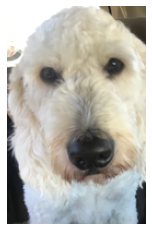

**Best guess: Soft-Coated Wheaten Terrier (confidence: 27.22%)**

Next best:

* Lakeland Terrier (17.23%)
* Goldendoodle (10.09%)
* Labradoodle (9.05%)
* Wire-Haired Fox Terrier (6.29%)
* Old English Sheepdog (5.70%)

---

Processing File_001.jpeg...


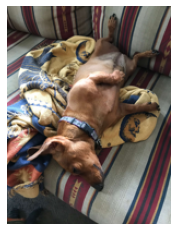

**Best guess: Italian Greyhound (confidence: 43.98%)**

Next best:

* Redbone (18.65%)
* Vizsla (11.96%)
* Miniature Pinscher (4.31%)
* Rhodesian Ridgeback (4.09%)
* Weimaraner (3.50%)

---

Processing File_002.jpeg...


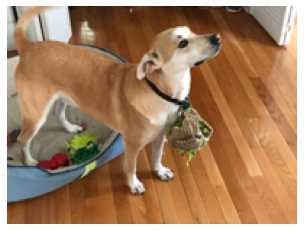

**Best guess: Italian Greyhound (confidence: 95.33%)**

Next best:

* Whippet (3.95%)
* Basenji (0.23%)
* Weimaraner (0.08%)
* Ibizan Hound (0.07%)
* Redbone (0.04%)

---

Processing File_003.jpeg...


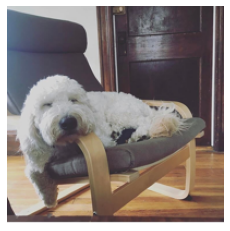

**Best guess: Old English Sheepdog (confidence: 33.38%)**

Next best:

* Soft-Coated Wheaten Terrier (31.90%)
* Komondor (15.78%)
* Sealyham Terrier (5.85%)
* Lakeland Terrier (4.78%)
* Bedlington Terrier (3.85%)

---

Processing File_004.jpeg...


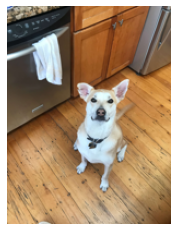

**Best guess: American Staffordshire Terrier (confidence: 31.05%)**

Next best:

* Pug (17.14%)
* Staffordshire Bullterrier (6.48%)
* French Bulldog (6.36%)
* Toy Terrier (6.17%)
* West Highland White Terrier (4.50%)

---

Processing File_005.jpeg...


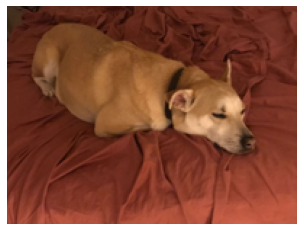

**Best guess: Labrador Retriever (confidence: 22.28%)**

Next best:

* Italian Greyhound (19.15%)
* Whippet (15.99%)
* American Staffordshire Terrier (14.83%)
* Chesapeake Bay Retriever (8.12%)
* Weimaraner (5.03%)

---

Processing File_006.jpeg...


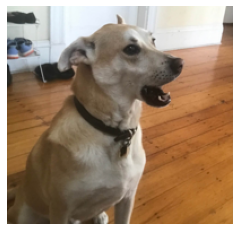

**Best guess: Italian Greyhound (confidence: 60.45%)**

Next best:

* Whippet (36.76%)
* Great Dane (1.19%)
* American Staffordshire Terrier (0.34%)
* Rhodesian Ridgeback (0.29%)
* Staffordshire Bullterrier (0.12%)

---

Processing File_007.jpeg...


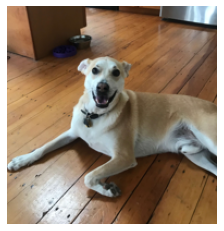

**Best guess: Labrador Retriever (confidence: 55.04%)**

Next best:

* Anatolian Shepherd Dog (7.59%)
* American Staffordshire Terrier (6.71%)
* Russell Terrier (5.41%)
* Italian Greyhound (3.21%)
* Rhodesian Ridgeback (1.59%)

---

Processing File_008.jpeg...


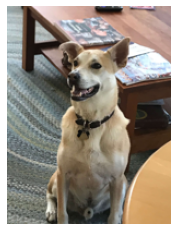

**Best guess: American Staffordshire Terrier (confidence: 17.39%)**

Next best:

* Labrador Retriever (14.85%)
* Carolina Dog (9.34%)
* Anatolian Shepherd Dog (6.90%)
* Whippet (6.89%)
* Staffordshire Bullterrier (5.38%)

---

Processing File_009.jpeg...


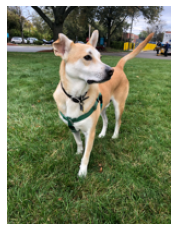

**Best guess: Italian Greyhound (confidence: 69.90%)**

Next best:

* Basenji (12.91%)
* Whippet (10.39%)
* Toy Terrier (1.28%)
* Chihuahua (1.11%)
* Carolina Dog (0.94%)

---

Processing File_010.jpeg...


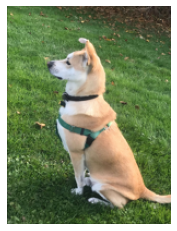

**Best guess: Basenji (confidence: 38.11%)**

Next best:

* Italian Greyhound (32.89%)
* Whippet (3.59%)
* Redbone (3.02%)
* Saluki (3.01%)
* Standard Poodle (2.25%)

---

Processing File_011.jpeg...


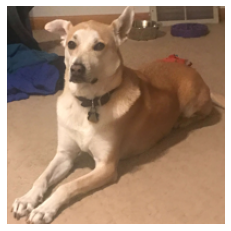

**Best guess: American Staffordshire Terrier (confidence: 33.13%)**

Next best:

* Labrador Retriever (23.35%)
* Staffordshire Bullterrier (13.19%)
* Great Dane (6.36%)
* Italian Greyhound (3.83%)
* Bull Mastiff (2.11%)

---

Processing File_012.jpeg...


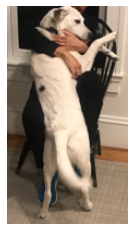

**Best guess: Great Pyrenees (confidence: 52.05%)**

Next best:

* Kuvasz (28.23%)
* Samoyed (17.28%)
* Pug (0.52%)
* Komondor (0.35%)
* Maltese Dog (0.21%)

---

Processing File_013.jpeg...


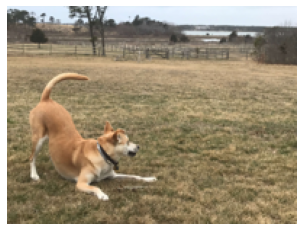

**Best guess: Whippet (confidence: 49.40%)**

Next best:

* Carolina Dog (14.89%)
* Cardigan Welsh Corgi (9.39%)
* Pembroke Welsh Corgi (6.59%)
* Saluki (3.92%)
* Malinois (1.75%)

---

Processing File_014.jpeg...


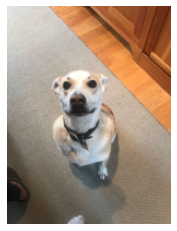

**Best guess: Pug (confidence: 32.49%)**

Next best:

* Labrador Retriever (22.68%)
* Chihuahua (9.96%)
* Lhasa (6.88%)
* Border Terrier (5.85%)
* Shih-Tzu (5.45%)

---

Processing File_015.jpeg...


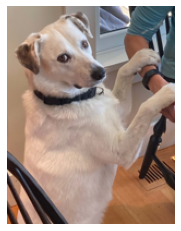

**Best guess: Italian Greyhound (confidence: 47.86%)**

Next best:

* Basenji (9.93%)
* Whippet (7.55%)
* Toy Terrier (4.57%)
* Redbone (2.85%)
* Miniature Pinscher (2.61%)

---

Processing File_016.jpeg...


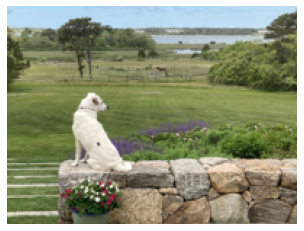

**Best guess: Standard Poodle (confidence: 17.33%)**

Next best:

* Borzoi (10.32%)
* Great Pyrenees (8.64%)
* Whippet (7.37%)
* Kuvasz (6.95%)
* Saluki (4.92%)

---

Processing File_017.jpeg...


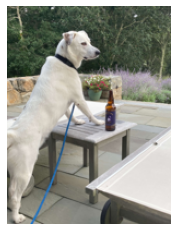

**Best guess: Labrador Retriever (confidence: 41.15%)**

Next best:

* Great Pyrenees (19.32%)
* Irish Wolfhound (6.12%)
* Anatolian Shepherd Dog (5.41%)
* American Staffordshire Terrier (5.14%)
* Kuvasz (3.65%)

---

Processing File_018.jpeg...


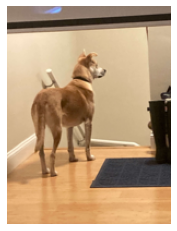

**Best guess: Carolina Dog (confidence: 77.43%)**

Next best:

* Shiba Inu (6.50%)
* Dhole (3.45%)
* Siberian Husky (1.61%)
* Malinois (1.57%)
* Kelpie (1.55%)

---

Processing File_019.jpeg...


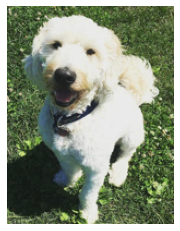

**Best guess: Old English Sheepdog (confidence: 43.56%)**

Next best:

* Kuvasz (14.30%)
* Great Pyrenees (10.39%)
* Maltese Dog (6.10%)
* Sealyham Terrier (2.27%)
* Soft-Coated Wheaten Terrier (2.04%)

---

Processing File_020.jpeg...


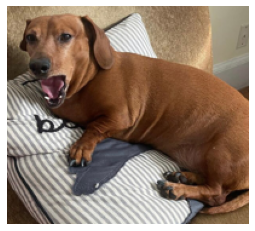

**Best guess: Rhodesian Ridgeback (confidence: 45.58%)**

Next best:

* Redbone (29.66%)
* Dachshund (8.19%)
* Labrador Retriever (2.90%)
* Vizsla (2.04%)
* Bloodhound (1.13%)

---

Processing File_021.jpeg...


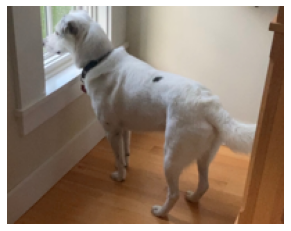

**Best guess: Maltese Dog (confidence: 63.70%)**

Next best:

* Great Pyrenees (16.83%)
* Labrador Retriever (3.07%)
* West Highland White Terrier (2.05%)
* Samoyed (1.85%)
* Coton de Tulear (1.72%)

---

Processing File_022.jpeg...


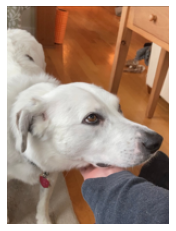

**Best guess: Great Pyrenees (confidence: 72.15%)**

Next best:

* Kuvasz (16.58%)
* English Setter (1.76%)
* American Staffordshire Terrier (1.60%)
* Labrador Retriever (1.08%)
* Samoyed (1.07%)

---

In [41]:
for url in dog_images:
    print(f"Processing {os.path.basename(url)}...")

    # must use PILImage.create, not Image.open, otherwise fastai doesn't work
    img = PILImage.create(requests.get(url, stream=True).raw)

    # get the top 6 predictions, then extract the top one so we have top 5 AFTER the best one
    pred, pred_idx, probs = learn.predict(img)
    top5_preds = sorted(list(zip(learn.dls.vocab, list(probs.numpy()))), key=lambda x: x[1], reverse=True)[:6]
    top_pred = top5_preds.pop(0)

    # output (1) the image (resized)
    #        (2) the top prediction
    #        (3) the next 5 best
    
    outstr = f"**Best guess: {top_pred[0]} (confidence: {100*top_pred[1]:.02f}%)**\n\n" + \
        "Next best:\n\n" + \
        '* ' + '\n* '.join([f'{x[0]} ({100*x[1]:.02f}%)' for x in top5_preds]) + \
        "\n\n---"

    plt.imshow(img.to_thumb(h=200))
    plt.axis('off')
    plt.show(block=False)  # forces plots to show immediately, interspersed with text, not at the end

    printmd(outstr)